# Dask Arrays from file

This is an example from [martindurant's repo](https://github.com/martindurant/dask-tutorial-scipy-2018). There you can find much more examples. [Here](https://www.youtube.com/watch?v=mqdglv9GnM8) you can find the fantastic presentation for which that repository was made.

We are going to use dask arrays to compute the mean of daily weather measurements over a month.

In [1]:
import os
import h5py
import dask.array as da
import matplotlib.pyplot as plt

We are working here with global weather data in hdf5 format (Hierarchical Data Format). Each hdf5 file takes about 576MB on `SCRATCH` and corresponds to a day measurements.

In [2]:
filenames = ['2014-01-01.hdf5', '2014-01-02.hdf5', '2014-01-03.hdf5',
             '2014-01-04.hdf5', '2014-01-05.hdf5', '2014-01-06.hdf5',
             '2014-01-07.hdf5', '2014-01-08.hdf5', '2014-01-09.hdf5',
             '2014-01-10.hdf5', '2014-01-11.hdf5', '2014-01-12.hdf5',
             '2014-01-13.hdf5', '2014-01-14.hdf5', '2014-01-15.hdf5',
             '2014-01-16.hdf5', '2014-01-17.hdf5', '2014-01-18.hdf5',
             '2014-01-19.hdf5', '2014-01-20.hdf5', '2014-01-21.hdf5',
             '2014-01-22.hdf5', '2014-01-23.hdf5', '2014-01-24.hdf5',
             '2014-01-25.hdf5', '2014-01-26.hdf5', '2014-01-27.hdf5',
             '2014-01-28.hdf5', '2014-01-29.hdf5', '2014-01-30.hdf5',
             '2014-01-31.hdf5']

Let's open the hdf5 files.

In [3]:
datadir = os.path.join('/scratch/snx3000/class256/weather-big')

dsets = [
    h5py.File(os.path.join(datadir, filename), mode='r')['/t2m']
    for filename in filenames
]

The code in the previous cell doesn't load the content of the hdf5 in memory. It just creates a list of hdf5 dataset objects which are <ins>*connected*</ins> to the files on disk.

In [4]:
dsets[0].shape

(5760, 11520)

Let's plot the values for one of the days

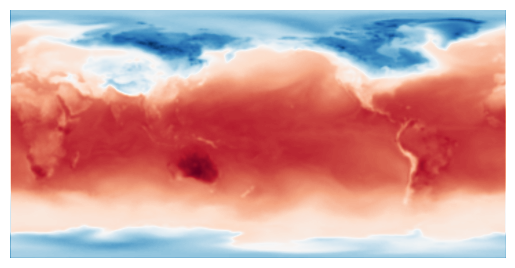

In [5]:
plt.imshow(dsets[0][::8, ::8], cmap='RdBu_r')  # We skip 8 elemnts in rows and columns (with the `::8`) to plot faster
plt.axis('off')
plt.show()

Often we need to do calculations that depend on all the days. For instance let's say that we need to calculate the average values over the month and plot it.

If we are not used to deal with large datasets, we would probably create a numpy array with all the data and compute the mean over the axis that represents the days. However, with data that doesn't fit in memory, that won't be possible. We would get a `MemoryError` exception (probably not in Piz Daint because the data is not big enough). Then we have to come up with a way to compute the averages array by array and modify significantly our scripts and workflows. 

In cases like this is where Dask arrays are useful.

## Connecting the hdf5 files to a Dask array

We first create a list of dask arrays, and stack it on a single one. Like this, from the point of view of the programmer, <ins>it feels like there is only a single hdf5 file on disk</ins>. 

In [6]:
arrays = [da.from_array(dset, chunks=(5760, 11520))
          for dset in dsets]
len(arrays)

31

In [7]:
x = da.stack(arrays)   # stack all the arrays in a single one
x

dask.array<stack, shape=(31, 5760, 11520), dtype=float64, chunksize=(1, 5760, 11520), chunktype=numpy.ndarray>

Here we only declared the array `x`. It is not loaded in memory.

In [8]:
x[0]

dask.array<getitem, shape=(5760, 11520), dtype=float64, chunksize=(5760, 11520), chunktype=numpy.ndarray>

At this point, nothing is loaded in memory. We have declared the Dask array `x`, which is connected to the hdf5 files on Disk. We we compute something Dask will fetch the data from Disk on demand.

Note that on the next cells we plot the data, but we don't call the `compute` method. This is because matplotlib *undaskifies* the array. In general that happens with functions that expect a numpy array.

In [9]:
mean = x.mean(axis=0)

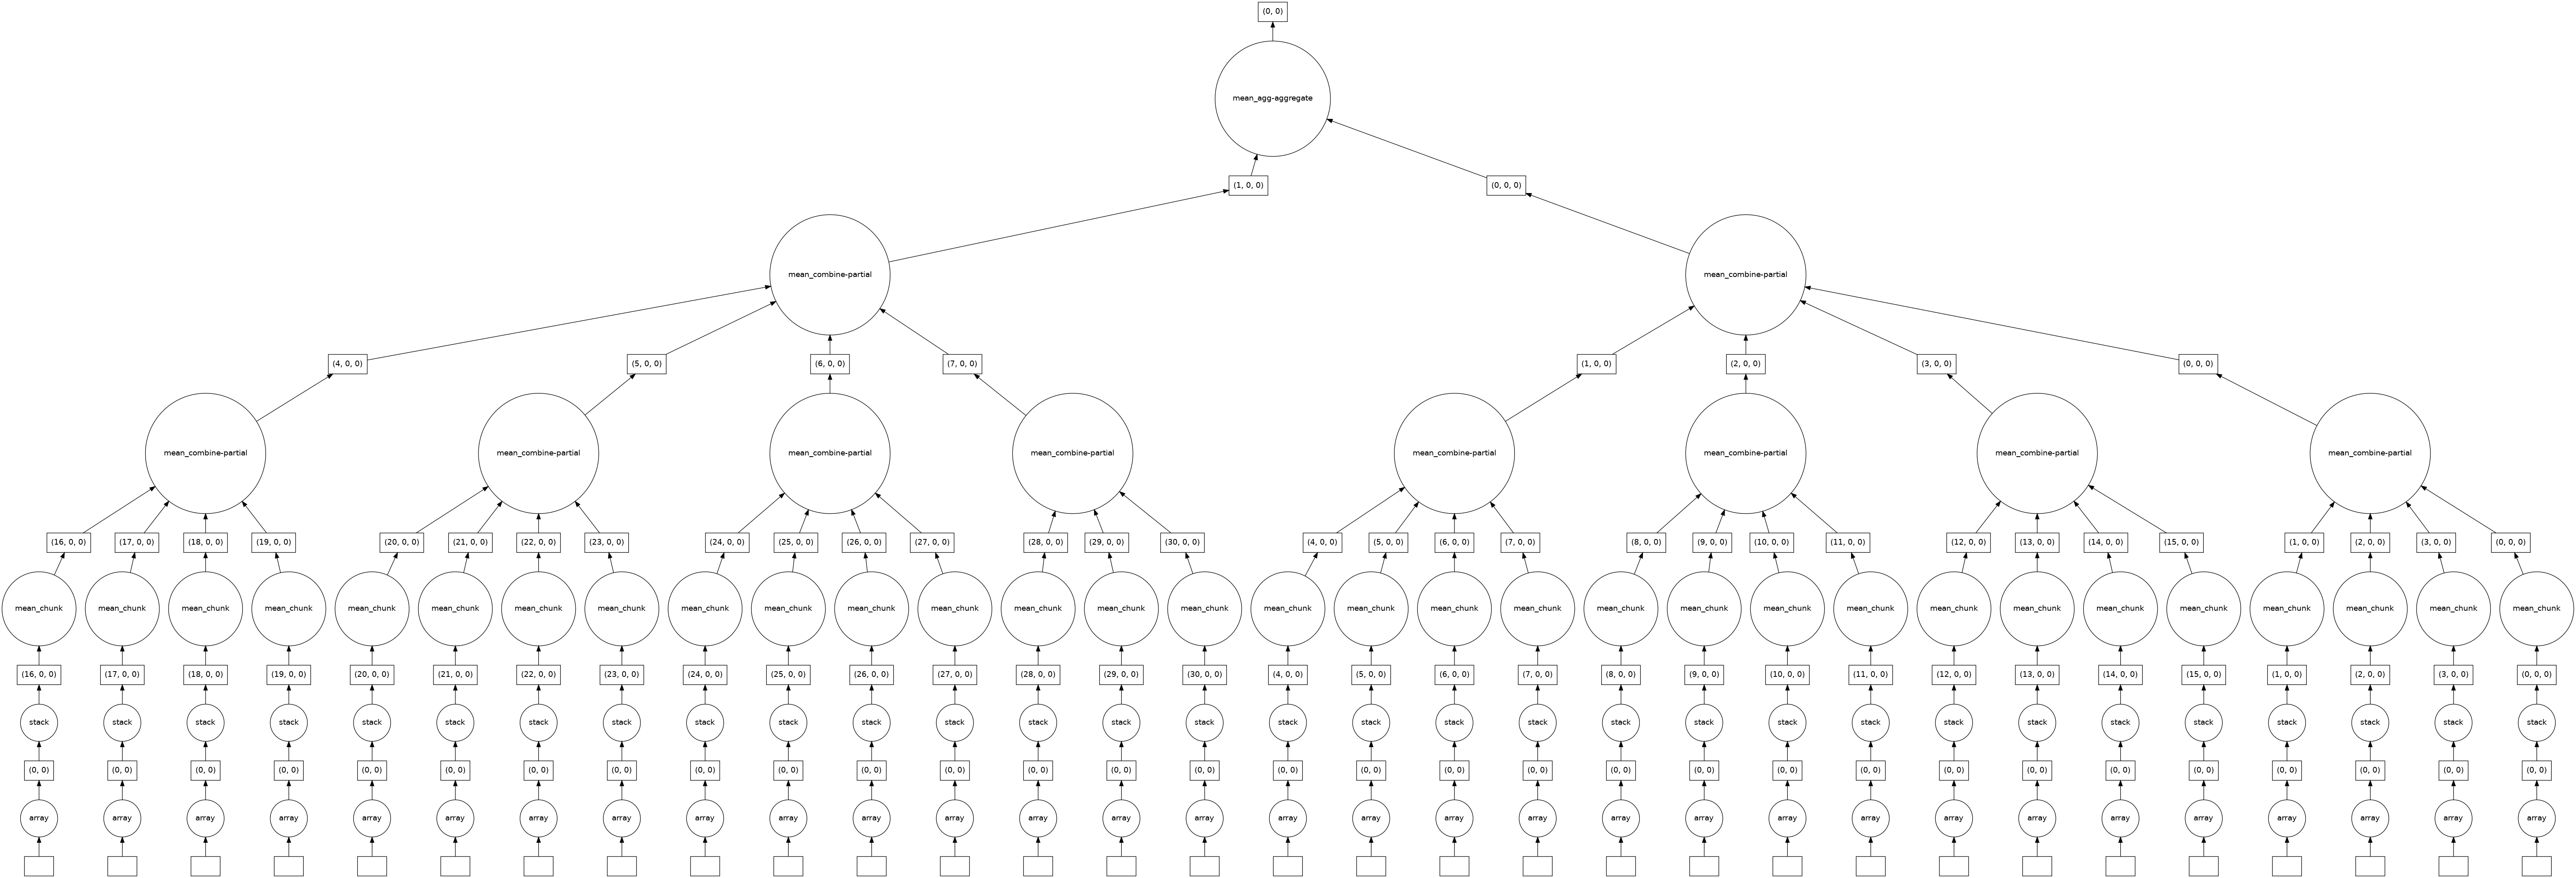

In [10]:
mean.visualize()

In [11]:
%%time
mean.compute();

CPU times: user 24.4 s, sys: 41.5 s, total: 1min 5s
Wall time: 34.7 s


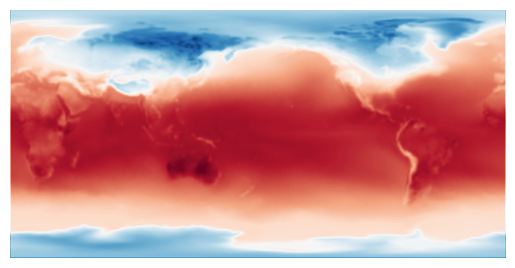

CPU times: user 28 s, sys: 37.2 s, total: 1min 5s
Wall time: 25.1 s


In [14]:
%%time
# plot the mean
plt.imshow(mean, cmap='RdBu_r')
plt.axis('off')
plt.show()

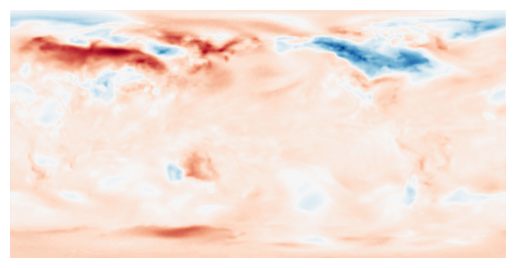

CPU times: user 27.7 s, sys: 37.6 s, total: 1min 5s
Wall time: 25.4 s


In [13]:
%%time
# plot the difference between day 1 and the mean.
result = x[0] - mean

plt.imshow(result, cmap='RdBu_r')
plt.axis('off')
plt.show()